# Project 4 - Advanced Lane Finding

The goal of this project is to write a software pipeline to identify the lane boundaries in a video recorded by a front camera mounted on a car. It also reports the relative location of the vehicle in the lane and the radius of the lane curvature. 

In [1]:
# import all necessary packages
import glob
import cv2
import numpy as np
#import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

### Prepare object and image points

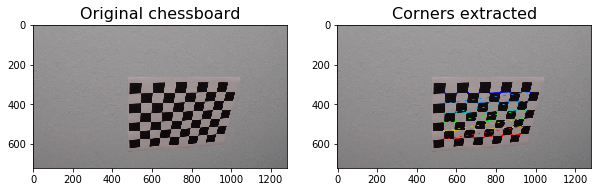

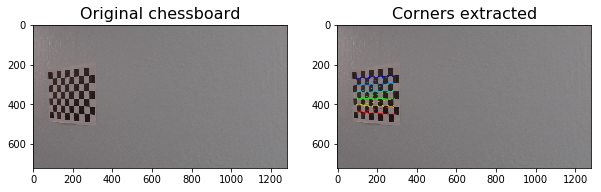

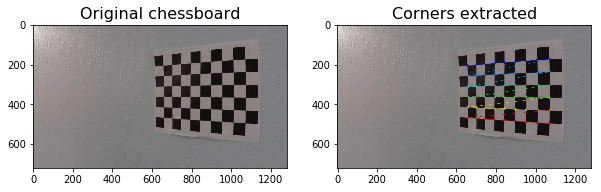

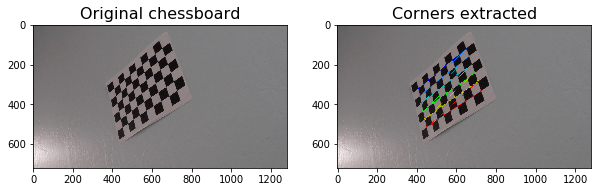

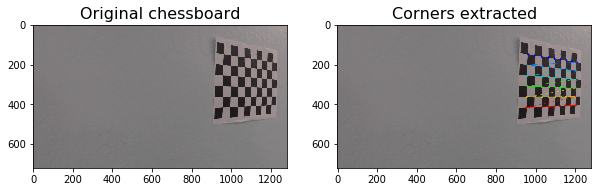

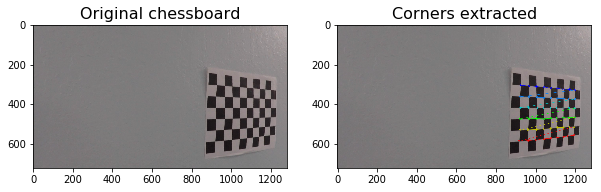

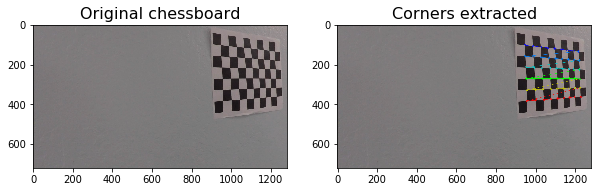

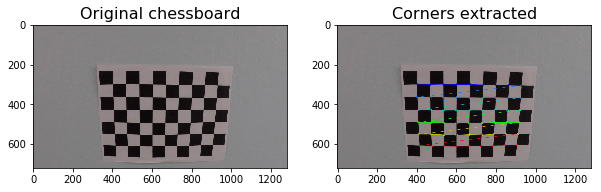

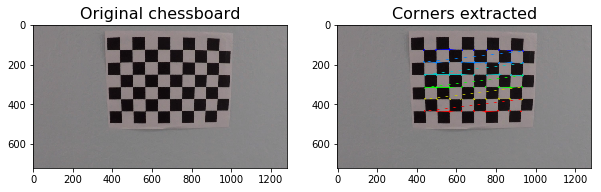

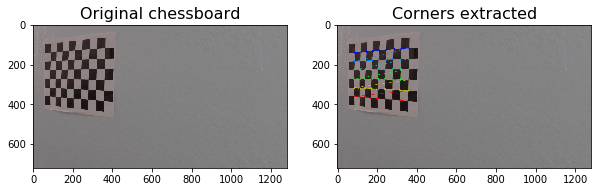

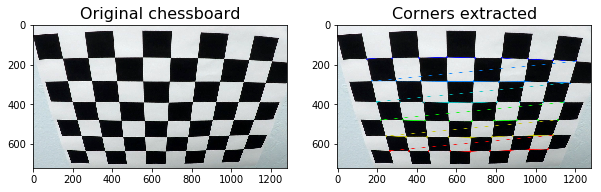

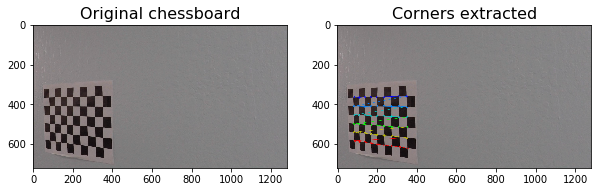

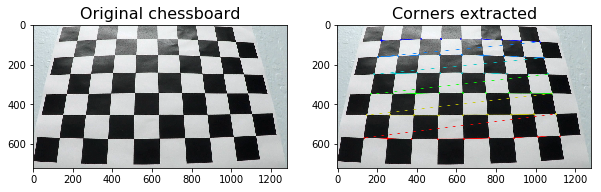

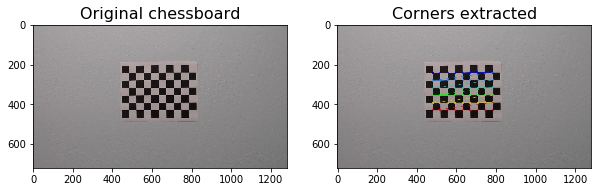

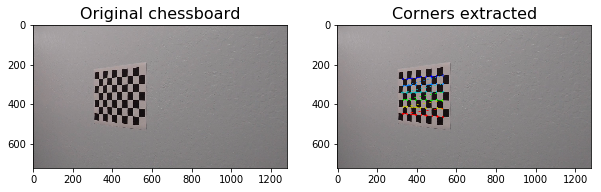

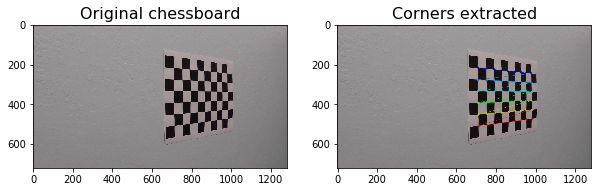

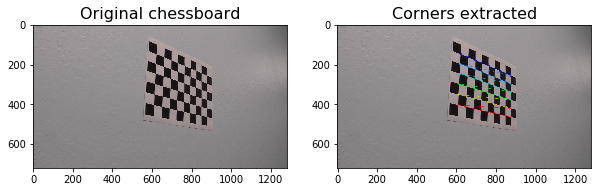

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# iterate through the list and search for chessboard corners
for idx, filename in enumerate(images):
    img = cv2.imread(filename)
    img_original=np.copy(img)
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(grayimg, (9,6), None)

    # if found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)

        # visualization
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(img_original)
        ax1.set_title('Original chessboard', fontsize=16)
        ax2.imshow(img)
        ax2.set_title('Corners extracted', fontsize=16)

### Define a function for undistortion

In [3]:
def cal_undistort(image):
    # define a function to remove distortion for later usage
    
    # test undistortion on an image
    #img = cv2.imread(image)
    img_size = (image.shape[1], image.shape[0])
    
    # camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    return img_undist

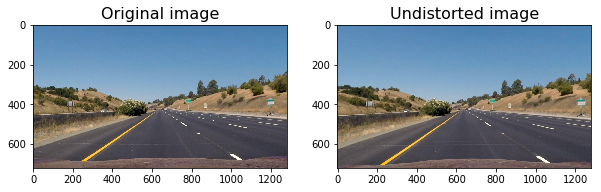

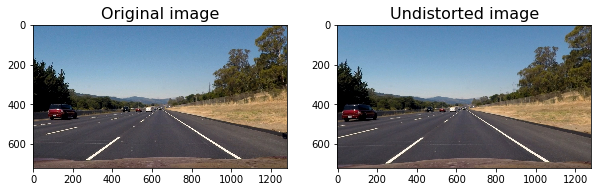

In [4]:
# visualize image undistortion
test_images = glob.glob('test_images/straight_lines*.jpg')
for test_image in test_images:
    test_image=cv2.imread(test_image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original image', fontsize=16)
    ax2.imshow(cv2.cvtColor(cal_undistort(test_image), cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted image', fontsize=16)


### Define a function for perspective transform

In [5]:
def transform(img):
    # define a function for perspective transform
    
    # call cal_undistort to get undisoted image
    img_undist = cal_undistort(img)
    img_undist_size = (img_undist.shape[1], img_undist.shape[0])
    
    #src and dst points I used
    src_points = np.float32([[510, 480], [770, 480], [1280, 720], [0, 720]])
    dst_points = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    
    # given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    # warp the image using OpenCV warpPerspective()
    img_warped = cv2.warpPerspective(img_undist, M, img_undist_size)

    return img_warped

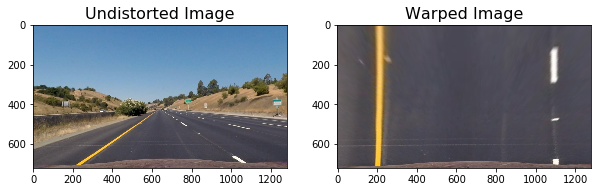

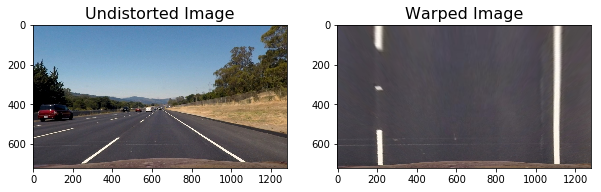

In [6]:
# visualize perspective transform
for test_image in glob.glob('test_images/straight_lines*.jpg'):
    test_image=cv2.imread(test_image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(cv2.cvtColor(cal_undistort(test_image),cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=16)
    ax2.imshow(cv2.cvtColor(transform(test_image), cv2.COLOR_BGR2RGB))
    ax2.set_title('Warped Image', fontsize=16)

### Define a function for binary thresholding

In [7]:
def threshold(img_warped):
    # define a function to create combine binary thresholds: 
    # The B channel from the LAB color space with threshold of (150,200), which identifies yellow lines well but ignores white
    # The L Channel from the LUV color space with threshold of (220,255),  which identifies white lines well but ignores yellow

    thresh1=[210,255]
    thresh2=[150,215]
    
    # get the L channel of LUV color space
    l_channel=cv2.cvtColor(img_warped, cv2.COLOR_BGR2LUV)[:,:,0]

    # create L channel binary threshold from LUV  
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh1[0]) & (l_channel <= thresh1[1])] = 1
    
    # get the b channel of Lab color space
    b_channel = cv2.cvtColor(img_warped, cv2.COLOR_BGR2Lab)[:,:,2]   

    # create B channel binary threshold from Lab
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh2[0]) & (b_channel <= thresh2[1])] = 1
    
    # combine the two thresholds together
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary

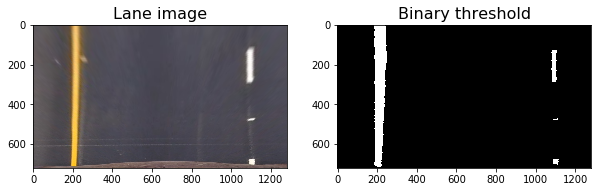

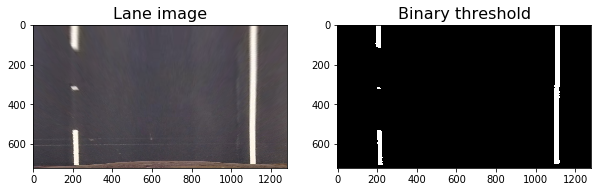

In [8]:
# visualize thresholding
for test_image in glob.glob('test_images/straight_lines*.jpg'):
    
    test_image=cv2.imread(test_image)
    
    f, (ax1, ax2)= plt.subplots(1, 2,  figsize=(10, 5))    
    ax1.set_title('Lane image', fontsize=16)
    ax1.imshow(cv2.cvtColor(transform(test_image), cv2.COLOR_BGR2RGB))  

    combined_binary_output=threshold(transform(test_image))
    ax2.set_title('Binary threshold', fontsize=16)
    ax2.imshow(combined_binary_output, cmap='gray')

### Define a function for fitting lane lines using sliding windows

In [9]:
def fit_with_window(binary_warped):
    # function to fit lane line points to a 2-degree polynominal
    
    # read in a warped binary image and make a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9   # the number of sliding windows
    window_height = int(binary_warped.shape[0]/nwindows)  # height of windows
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = np.nonzero(binary_warped)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100   # the width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = np.nonzero(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)))[0]
        good_right_inds = np.nonzero(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)))[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a 2nd order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit

In [10]:
def fit_skip_window(binary_warped, left_fit,right_fit): 
    # fit lane lines without sliding window, searching in a nearby region
    
    # this time compute same varialbes using left_fit and right_fit returned from fit_with_window()
    nonzero = np.nonzero(binary_warped)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # fit a 2nd order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit

In [11]:
def curvature(left_fit,right_fit): 
    # compute lane curvature giving left_fit and right_fit coefficients
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    curvature=int((left_curverad+right_curverad)/2)
    
    return curvature

In [12]:
def distance(left_fit,right_fit):
    # compute distance from lane center giving left_fit and right_fit coefficients
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # get the midpoint of the lane
    mid_lane = (left_fitx[0]+right_fitx[0])/2
    
    # midpoint of the camera image
    mid_image=1279/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    distance = abs((mid_image - mid_lane)*xm_per_pix) 
    distance=round(distance,2)
    
    return distance

C:\Users\Solo\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


lane curvature is 5249 m
distance from center is 0.08 m


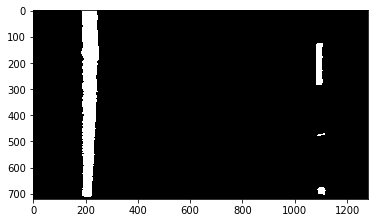

In [13]:
# test curvature and distance function 
img=cv2.imread('test_images/straight_lines1.jpg')
binary_warped=threshold(transform(img))
plt.imshow(binary_warped, cmap='gray')

left_fit,right_fit=fit_with_window(binary_warped)

print('lane curvature is',curvature(left_fit,right_fit), 'm')

print('distance from center is',distance(left_fit,right_fit), 'm')

In [14]:
class Line:
    #create a Line class to store important parameters 
    def __init__(self):
        # whether this lane is detected in last iteration
        self.detected = False  
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        #polynomial coefficients for the most recent fit
        self.A = []
        self.B = []
        self.C = []
        
        #fitted x points for plotting
        self.fitx = None   
        
        # x intercepts        
        self.x_bottom = []
        self.x_top = []
        
        # lastest interpects
        self.x_bottom_last = None
        self.x_top_last = None

In [15]:
def threshold_frame(image):
    # slightly modified version of threshold() for processing video frame

    thresh1=[210, 255]
    thresh2=[150, 215]
    # transform and warp the image
    img_warped= transform(image)

    l_channel = cv2.cvtColor(img_warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh1[0]) & (l_channel <= thresh1[1])] = 1

    b_channel = cv2.cvtColor(img_warped, cv2.COLOR_RGB2Lab)[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh2[0]) & (b_channel <= thresh2[1])] = 1 

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    return combined_binary

In [16]:
def process_frame(image):
    # function for process each frame of the video
    
    # prepare undistorted image
    img_undist=cal_undistort(image)
    
    # set scr and dst points used, as the same when doing persepctive transform
    src = np.float32([[510, 480], [770, 480], [1280, 720], [0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    
    # get binary image
    combined_binary=threshold_frame(image)
    
    # creat lists to store pixels of both left and right lane lines 
    x_left = []
    y_left = []
    x_right = []
    y_right = []
     
    # find non zero pixels
    valid_x, valid_y = np.nonzero(np.transpose(combined_binary)) 
  

    # set the sliding search area height and width, also the search window size
    search_height=720
    search_width=int(1280/2)-10
    search_window=90
    half=640  #half horizontal length of the image

    
    ########## sliding window finding lane lines or skip window ###############
    
    # find the right lane from nearby region of previous fit
    if right_line.detected == True: 
        height = search_height
        width = search_width
        while width >= 0:
            # get pixel values
            y = np.mean([height,width])
            x = (np.mean(right_line.A))*y**2 + (np.mean(right_line.B))*y + (np.mean(right_line.C))
            x_index = np.where(( ( (valid_y < height) & (valid_y > width) )  &  (valid_x < (x + 25)) & ((x - 25) < valid_x)  ))
            x_found, y_found = valid_x[x_index], valid_y[x_index]
            if len(x_found) != 0:
                np.append(x_right, x_found)
                np.append(y_right, y_found)       
            height =height- search_window
            width =width- search_window
        if len(x_right) == 0:
            right_line.detected = False # If no lane pixels were detected then perform blind search
    else: # if nothing found, do a blind search again
        height = search_height
        width = search_width
        while width >= 0:
            hist = np.sum(combined_binary[width:height,:], axis=0)
            rightx_base = np.argmax(hist[half:]) + half   # only search right half
            x_index = np.where(( ((valid_y > width) & (valid_y < height)) &  (valid_x < (rightx_base + 25))  &  ((rightx_base - 25) < valid_x)   ))
            x_found, y_found = valid_x[x_index], valid_y[x_index]
            if len(x_found) != 0: # append if found
                x_right=np.append(x_right,x_found)
                y_right=np.append(y_right,y_found)
            height =height- search_window
            width =width- search_window
    if len(y_right) == 0:
        y_right = right_line.ally
        x_right = right_line.allx       
  
           #########################################  

    # find the left lane from nearby region of previous fit
    if left_line.detected == True: # Search for left lane pixels around previous polynomial
        height = search_height
        width = search_width
        while width >= 0:
            # get pixel values
            y = np.mean([height,width])
            x = (np.mean(left_line.A))*y**2 + (np.mean(left_line.B))*y + (np.mean(left_line.C))
            x_index = np.where( (((valid_y > width) & (valid_y < height)) & (valid_x < (x + 25))&((x - 25) < valid_x)) )
            x_found, y_found = valid_x[x_index], valid_y[x_index]
            if len(x_found) != 0: # append if found
                np.append(x_left, x_found)
                np.append(y_left, y_found)
            height =height- search_window
            width =width- search_window
        if len(x_left) == 0: 
            left_line.detected = False # If no lane pixels were detected then perform blind search
    else: # if nothing found, do a blind search again
        height = search_height
        width = search_width
        while width >= 0:
            hist = np.sum(combined_binary[width:height,:], axis=0)
            leftx_base = np.argmax(hist[:half])  # only search left half
            x_index = np.where(  (  ((valid_y > width) & (valid_y < height)) &  (valid_x < (leftx_base + 25))&  ((leftx_base - 25) < valid_x)   ))
            x_found, y_found = valid_x[x_index], valid_y[x_index]
            if len(x_found) != 0:
                x_left=np.append(x_left,x_found)
                y_left=np.append(y_left,y_found)
            height =height- search_window
            width =width- search_window
    if len(y_left) == 0:
        y_left = left_line.ally
        x_left = left_line.allx

    ####################### end of find #########################     
        
        
        
    # make pixels to np array    
    x_right = np.array(x_right).astype(np.float32)   
    y_right = np.array(y_right).astype(np.float32)
    x_left = np.array(x_left).astype(np.float32)
    y_left = np.array(y_left).astype(np.float32)
    
        
    
    ########### fit left lane and store useful paramters back to lane instance ###############
        
    # fit detected pixels to a 2nd degree polynomial for left lane
    fit_left = np.polyfit(y_left, x_left, 2)
    
    # max and min value of image height
    h_max=720
    h_min=0
    
    # compute intercepts 
    x_top_left = fit_left[0]*h_min**2 + fit_left[1]*h_min + fit_left[2]
    x_bottom_left = fit_left[0]*h_max**2 + fit_left[1]*h_max + fit_left[2]
    
    # append intercepts to lefe_line list
    left_line.x_top.append(x_top_left)
    left_line.x_bottom.append(x_bottom_left)  
    
    # average x intercepts among frames
    x_bottom_left = np.mean(left_line.x_bottom)
    x_top_left = np.mean(left_line.x_top)
    
    # store latest intercepts back
    left_line.x_top_last = x_top_left
    left_line.x_bottom_last = x_bottom_left
        
    # append points back
    x_left=np.append(x_left, x_top_left)
    x_left=np.append(x_left, x_bottom_left)
    y_left=np.append(y_left, h_max)
    y_left= np.append(y_left, h_min)
    
    # sort and assign back to lane line instance
    index_sort = np.argsort(y_left)
    y_left = y_left[index_sort]
    x_left = x_left[index_sort]
    left_line.allx = x_left
    left_line.ally = y_left
    
    # now average the fit amony frames
    fit_left = np.polyfit(y_left, x_left, 2)
    
    # append new ploy coeffcients back to lane instance
    left_line.A.append(fit_left[0])
    left_line.B.append(fit_left[1])
    left_line.C.append(fit_left[2])
    
    # average the stored ploy coeffcients
    fit_left = [np.mean(left_line.A), np.mean(left_line.B), np.mean(left_line.C)]
    
    # polynomial fit
    left_fitx = fit_left[0]*y_left**2 + fit_left[1]*y_left + fit_left[2]
    left_line.fitx = left_fitx
    
    
    
    
    ########### fit right lane and store useful paramters back to lane instance ###############
    
    # fit detected pixels to a 2nd degree polynomial for left lane
    fit_right = np.polyfit(np.int_(y_right), np.int_(x_right), 2)
  
    # compute intercepts
    x_top_right = fit_right[0]*h_min**2 + fit_right[1]*h_min + fit_right[2]
    x_bottom_right = fit_right[0]*h_max**2 + fit_right[1]*h_max + fit_right[2]
     
    # append intercepts to right_line list
    right_line.x_top.append(x_top_right)
    right_line.x_bottom.append(x_bottom_right)
     
    # average x intercepts among frames 
    x_top_right = np.mean(right_line.x_top)
    x_bottom_right = np.mean(right_line.x_bottom)
    
    # store latest intercepts back
    right_line.x_top_last = x_top_right
    right_line.x_bottom_last = x_bottom_right
    
    # append points back
    x_right=np.append(x_right, x_top_right)
    x_right=np.append(x_right, x_bottom_right)
    y_right=np.append(y_right, h_max)
    y_right=np.append(y_right, h_min)
    
    # sort and assign back to lane line instance
    sort_index = np.argsort(y_right)
    y_right = y_right[sort_index]
    x_right = x_right[sort_index]
    right_line.allx = x_right
    right_line.ally = y_right
    
    # now average the fit amony frames
    fit_right = np.polyfit(y_right, x_right, 2)
    
    # append new ploy coeffcients back to lane instance
    right_line.A.append(fit_right[0])
    right_line.B.append(fit_right[1])
    right_line.C.append(fit_right[2])
    
    # average the stored ploy coeffcients
    fit_right = [np.mean(right_line.A), np.mean(right_line.B), np.mean(right_line.C)]
    
    # polynomial fit
    right_fitx = fit_right[0]*y_right**2 + fit_right[1]*y_right + fit_right[2]
    right_line.fitx = right_fitx
            
        
    
    ############# do a little filtering ################
        
    # set filtering depth
    depth=10
        
    # store useful characteristics of each lane line for filtering
    # left lane
    if len(right_line.x_top) > depth:
        right_line.x_top.pop(0) 
    if len(right_line.x_bottom) > depth:
        right_line.x_bottom.pop(0)
    if len(right_line.A) > depth:
        right_line.A.pop(0)
    if len(right_line.B) > depth:
        right_line.B.pop(0)
    if len(right_line.C) > depth:
        right_line.C.pop(0)
    # right lane    
    if len(left_line.x_bottom) > depth:
        left_line.x_bottom.pop(0)
    if len(left_line.x_top) > depth:
        left_line.x_top.pop(0)
    if len(left_line.A) > depth:
        left_line.A.pop(0)
    if len(left_line.B) > depth:
        left_line.B.pop(0)
    if len(left_line.C) > depth:
        left_line.C.pop(0)
    
        
         
    ################## draw filled lane back #####################    
    
    # create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_line.fitx, left_line.ally])))])
    pts_right = np.array([np.transpose(np.vstack([right_line.fitx, right_line.ally]))])
    pts = np.hstack((pts_left, pts_right))
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_(pts), (0,255,0))
    # compute the iverse transform matrix to warp detected lane back    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    
    ################ print out curvature & distance ##################
    
    # print radius of curvature by calling curvature(fit_left,fit_right) function
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(curvature(fit_left,fit_right)), (750,50),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 3)
  
    # print distance by calling distance(fit_left,fit_right) function
    cv2.putText(result, 'Car is {:.2f}m off center'.format(distance(fit_left,fit_right)), (50,50),  fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 3)
    
    return result

In [17]:
from moviepy.editor import VideoFileClip
left_line=Line()
right_line=Line()

clip = VideoFileClip("project_video.mp4")
video_output = 'result.mp4'
white_clip = clip.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [34:20<00:01,  1.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [18]:
from IPython.display import HTML
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [19]:
left_line=Line()
right_line=Line()

clip = VideoFileClip("challenge_video.mp4")
video_output = 'result_challenge.mp4'
white_clip = clip.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result_challenge.mp4
[MoviePy] Writing video result_challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [12:25<00:00,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_challenge.mp4 



In [20]:
from IPython.display import HTML
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format('result_challenge.mp4'))